# Dropout Exploration

In this notebook I will explore Dropout in Fully Connected Networks, the motivation behind it and why it works both from a theoratical and practical standpoint. The starter code is taken from CS182. 

## Theoretical standpoint:


##### How it works:

*During Training: (Stochastic Masking):* 

+ While training on our minibatch, randomly ”kill” certain units by setting them to zero before training. We will have a hyperparameter that provides the probability of ”nulling” out a unit, $p$. So for each forward pass we generate a binary mask $\mathbf{m}$ whose entries $m_i$​ are independent Bernoulli random variables: $m_i \sim \operatorname{Bernoulli}(p)$. We apply the mask to the output of a given layer, so the output becomes, $\tilde{x}=m⊙x$. 
+  The mask is typically re-sampled for every mini-batch (or even every example in the batch). This means that at every update, the network effectively samples a different sub-network.
-  For any neuron that is “dropped” (i.e., $m_i = 0$), its downstream contributions become zero. During backpropagation, the gradients for those neurons are zero as well. This means the corresponding weights are not updated during that iteration. We can think of the remaining weights ”shaking” a bit to pick up the slack. 

*Evaluation:*

+ The standard way evaluation is done after dropout is to use expected behavior.  
     *Example:* Lets say we’re killing certain units with probability $\frac{1}{2}$ . This means that our unit, $x$, is outputting $0$ half the time and $ReLU(x)$ the other half of the time. We can calculate the expected behavior of our unit as  $\frac{1}{2} · ReLU (x) + \frac{1}{2} · 0$. This essentially halves the output of our neuron during evaluation to account for us ”nulling out” half the neurons while training.
+ In practice, we usually implement *Inverted Dropout* were we rescale activations during training (By multiplying with the probability $p$) and then in test time infer directly with the resulting weights. You can check why this works by simply deriving the expected values for each output $\tilde{x}$. 
##### Why it works:

There are few perspectives to look at *why* Dropout works:

+ It's a form of regularization it helps normalize the feature matrix gradient operates on, by normalizing it's entries. This normalization smoothens the loss landscape, improves the condition number and leads to better and faster convergence (We can use a *bigger learning rate*). We will see how this actually plays out by looking, as usual at the $GLM$ of neural nets.

> Aside:
> At first glance it might look like Dropout might lead to slower convergence because we are not updating weights as frequently but this is negated by the fact that we can increase the learning rate since we have a better-conditioned matrix. This is why Learning rate and dropout are trained together, so while dropout does reduce the size of our gradients, the learning rate can compensate for that.

+ By normalizing the feature matrix with Dropout, we are essentially neutralizing the effect of large singular values, I wrote before about how $GDs$ inductive bias is to converge first in directions of larger singular values, which we hope correspond to meaningful data patterns. Now we still want to converge to those directions with bigger $\sigma$ (Hence early-stopping) *BUT* we want their magnitude to stem from cross-correlation and not from the raw magnitudes themselves. 
+ When we say they are big by cross-correlation, that's not really accurate, what we mean is, many principal vectors point in somewhat the same direction, so the small updates in all of those directions can appear as one big update, mimicking the same effects of a big singular value.  
+ The previous point leads to the known effect of Dropout which is to lead to the whole network learning meaningful patterns rather than relying on one node to do so (distributed representation).

> Why do we want cross-correlation ? 
> 
> I already highlighted why this is important in the context of optimization (Better conditioning). But there are other aspects rooted in statistical learning theory and information theory. 
> 
> When we prefer cross-correlation over large singular values, we're essentially favoring distributed representations over concentrated ones. 
> 
> In real-world data, important features often manifest as patterns that appear across multiple dimensions/features rather than being concentrated in single directions. Think of how an object in an image is recognized through the combination of multiple lower-level features (edges, textures, shapes) rather than single powerful detector.
>
> When multiple nodes/features are correlated in their response to meaningful patterns, it suggests these patterns are robust and not artifacts. This can be formalized through the Information Bottleneck principle: features that emerge from multiple weakly correlated signals are more likely to represent true task-relevant information rather than noise

+ How cross-correlation is favored by dropout can actually be seen in another perspective than the normalization one, when multiple features are cross-correlated, their joint contribution to the gradient remains significant even under random masking, while isolated large values are proportionally reduced. 
+ Now, It was first hypothesized that Dropout effect is neutralized when we use $BN$, since they basically serve the same purpose *per* the previous points (Smoothing the loss landscape and its implications), but in practice this is not valid, as having both preforms better.
+ This might be attributed to the fact that Dropout preforms a kind of implicit ensemble learning. Dropout has been interpreted as training an ensemble of $2^n$ thinned networks (where $n$ is the number of neurons subject to dropout). Although these sub-networks share weights, each mini-batch update is effectively performed on a different architecture. At test time, using the full network with scaled weights corresponds to averaging the predictions of all these sub-networks (Taking the expectation). This ensemble effect is known to improve generalization performance.
##### Regularization and Dropout (GLM connection):

Let's look at Dropout from the perspective of Linear regression and then we can map it to Neural Nets using the GLM model to help better understand what it does. 

Linear regression learning Objective:  $L(w) = ||y - Xw||^2_2$

One way of using dropout during $SGD$ on the d-dimensional input features $x_i$ involves keeping each feature at random $∼_{i.i.d}$ Bernoulli(p) (and zeroing it out if not kept) and then performing a traditional $SGD$ step. This give off the following learning objective:

$$L(\hat{w}) = E_{R \sim \text{Bernoulli}(p)} \left[ ||y - (R \odot X)\hat{w}||^2_2 \right] \ \ \dots \ (2)$$

Where:
- $\odot$ is element-wise product
- $R \in \{0,1\}^{n \times d}$ is a random binary matrix
- $R_{i,j} \sim_{i.i.d}$ Bernoulli(p)

So dropout acts on the matrix $X$, which corresponds in the Generalized Linear Model of Neural Networks to the feature matrix $\Phi(x)$. 

Now we need to know how does it act on $X$ and what's it's effect on the learned weights $w$. 

When we get rid of the expectation, we can find that:

$$L(\hat{w}) = ||y - pX\hat{w}||^2_2 + p(1-p)||\hat{\Gamma}\hat{w}||^2_2 \ \ \ \ \dots (1)$$

Where $\hat{\Gamma}$ is a diagonal matrix with diagonal entries being the norms of X's columns. $\hat{\Gamma} = (diag(X^TX))^{1/2}$ , this is a very important insight.  

We can find equation $(1)$ by expanding the squared-error and applying the linearity of the expectation. An important insight is that the expected value of a matrix is the matrix of the expected value of its elements

Equation $(1)$ looks very similar to the *Tikhonov-regularized* least-squares problem.

To get a solution similar to traditional regularization, we can choose $w = p\hat{w}$  absorbs the $p$ term into $w$ and allows choosing $\Gamma$ accordingly, we would find then: 
$$L({w}) = ||y - X{w}||^2_2 + ||{\Gamma}{w}||^2_2 \ \ \ \ \dots\ (4)$$
*Where:* 

+ $Γ = \sqrt{\frac{1−p}{p}}\hat{Γ} = c\hat{Γ}$, where $c$ is a scaling constant.   


Let's transform equation $(4)$ even further to the classical ridge regression formula, 
$$L(\tilde{w}) = ||y - \tilde{X}\tilde{w}||^2_2 + \lambda||\tilde{w}||^2_2  \ \ \ \ \ \dots \  \ (5) $$
*Where:* 
+ $\tilde{w} = \Gamma w$ 
+ And the modified data matrix: $\tilde{X} = X\Gamma^{-1}$


Let's understand the full picture now, 

So dropout in eq. $(1)$ is equivalent to learning a solution by ridge regression where: 
$X = XΓ^{−1} = cX\hat{Γ}^{−1}$ and $\hat{w} = \frac{c}{p} \hat{\Gamma}^{-1}\tilde{w}$.  

we know that $\hat{Γ}^{−1}$ contains the norms of each column in $X$, so each entry of the new matrix is normalized up to a scaling factor $c$. 

In other words, dropout makes each column vector of the matrix $X$ constant-norm of $c$ in effect. 

This is very similar to batch-normalization’s standardization and scaling operations, which makes the column vectors have the same variance. And from here stems the argument that they  essentially do the same thing. 

>The thing is Dropout does more than that, in addition to normalizing the matrix $X$, it solves a regularized least-squares instead of $OLS$, so there's a form of double-regularization, one stemming from the normalization of the matrix (and its effects on the loss-landscape and the magnitude of singular values) and the other from the added ridge-regularization (the constant $\lambda$ regularizes the inverse of the singular values even further). 


Now since we fully understand the regularizing effect of Dropout, let's go full circle and try to connect it to Neural Networks.  

The Generalized Linear model of Fully Connected Network, 

During training, the optimization algorithm and the model’s *output* can be approximated locally as a linear function of the parameter changes $\Delta \vec{\theta}$, so The Generalized Linear model of Fully Connected Network, can be given by: 

$$f(x; \theta) = f(x, \theta_0) + \left. \frac{d{f}}{d\theta} \right|_{\theta_0} \cdot \Delta \vec{\theta}
$$
If we attach a squared-error loss to the output we get a linear regression problem, this is a loose comparison and only in the purpose of better understanding Dropout.

So when we apply dropout to the different outputs of the neural network, we are *loosely* applying it to the feature matrix (since the derivatives are tightly coupled with the magnitude of the outputs). So the previous equation can be, again, loosely tied to eq. $(2)$. Which means that Dropout:

1. Normalizes the feature matrix, allowing for a smoother loss landscape and a larger effective condition number (same as Batch Normalization, hence the confusing similarity *BUT* an important distinction is that dropout is stochastic where BN is deterministic, and in addition to scaling $BN$ centers features, I need to understand better why centring is important)
2. Regularizes the learned weights (in this case the next-step gradient), which combats overfitting and the exploding gradient problem, which means that, similar to the ridge regression case, dropout **reduces the effective scale of the gradients**, this is known as gradient shrinking effect.

> The previous analysis is valid in Expectation, but it does not capture the variance introduced by Dropout. A more rigorous derivation would involve **second-order moments** (i.e., variance analysis) to characterize how dropout affects gradient updates over multiple steps.  
> 
> This same analysis can be justified by treating Dropout as Noise injection and working on *OLS* with instance-noise.


In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Problem Intro

We will explore the effect of dropout on a simple gradient descent problem. We will train weights $w_1$ and $w_2$ to solve the linear equation $10w_1 + w_2 = 11$, where $w_1$ and $w_2$ are initialized at 0.

We formulate this question as an OLS:

$$\min_{\mathbf{w}} \lVert \mathbf{Xw} - \mathbf{y} \rVert^2 $$,

where $\mathbf{X}, \mathbf{y}$ are:

In [4]:
x = np.array([[10, 1]])
y = np.array([[11]])

## No Dropout, Least-Square

Analytically show what solution we will converge to if we train with gradient descent and an appropriately small learning rate. Take advantage of the fact that when you initialize weights to 0 and train linear regression with gradient descent, you recover the least-squares solution.

**Complete the following code** to calculate this solution in python, but you can also use another tool and insert your answer.
(HINT: use `np.linalg.pinv`)

In [5]:
w = np.linalg.pinv(x) @ y
print(w)

[[1.08910891]
 [0.10891089]]


### Question

Please **include the mathematical expression in your written** assignment submission, and **copy and paste the output of the previous cell** into your submission as well.

## No Dropout, Gradient Descent

Show training with gradient descent recovers the expected solution. A training loop has been provided for you.

In [6]:
def train_simple(net, lr=.001, batch_size=1, itrs=1000, plot=True, optim_class=torch.optim.SGD, x=None, y=None):
    optimizer = optim_class(net.parameters(), lr=lr)

    losses = []
    if x is None:
        x = torch.FloatTensor([[10, 1]])
        y = torch.FloatTensor([[11]])
    else:
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y)
    # Repeat element batch_size times
    x = x.repeat(batch_size, 1)
    y = y.repeat(batch_size, 1)
    for i in range(itrs):
        y_hat = net(x)
        loss = torch.nn.MSELoss()(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if plot:
        plt.plot(losses)
        plt.show()
        print_weights(net)
    return losses

def print_weights(net):
  print(f'Weights: {net.state_dict().values()}')

**Complete the following code to create the linear network for the OLS in PyTorch.**

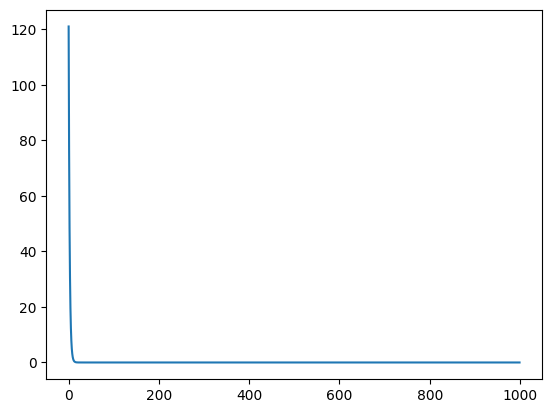

Weights: odict_values([tensor([[1.0784, 0.1078]]), tensor([0.1078])])


In [7]:
net = nn.Linear(2, 1)
# Initialize weights with 0
net.load_state_dict({k: v * 0 for k, v in net.state_dict().items()})
losses = train_simple(net)

### Question

Please **copy and paste the output of the previous cell** (text only) into your submission of the written assignment. **Are the weights obtained by training with gradient descent the same as those calculated using the closed-form least squares method?** Answer this question in your written assignment.

## Dropout, Least-Square

Now we add a dropout rate of `p=0.5`, which means that during each forward pass, each input to the network has a 50% probability of being set to `0`. To account for this reduction in the number of inputs, we also need to scale the inputs by `2`. However, during testing, we do not apply any dropout, nor do we scale the inputs.

By dropping out each element in the input with a 50% probability, we create a dataset with *four* equally likely inputs, in which $w_1$ is dropped out, $w_2$ is dropped out, both are dropped out, or neither is dropped out. This is our new dataset, represented by `x` and `y`. Using this dataset, we can compute the analytic solution to improve our network's performance.

**Complete the following code according to the instructions above:**

In [8]:
x = np.array([[20, 2], [0, 2], [20, 0], [0, 0]])
y = np.array([[11], [11], [11], [11]])
w = np.linalg.pinv(x) @ y
print("x =", x)
print("y =", y)
print("w =", w)

x = [[20  2]
 [ 0  2]
 [20  0]
 [ 0  0]]
y = [[11]
 [11]
 [11]
 [11]]
w = [[0.36666667]
 [3.66666667]]


### Question

Please **copy and paste the output of the previous cell** (text only) into your submission of the written assignment.

## Dropout, Gradient Descent
**Add dropout to your network. Implement the Dropout layer below, then run with dropout.**

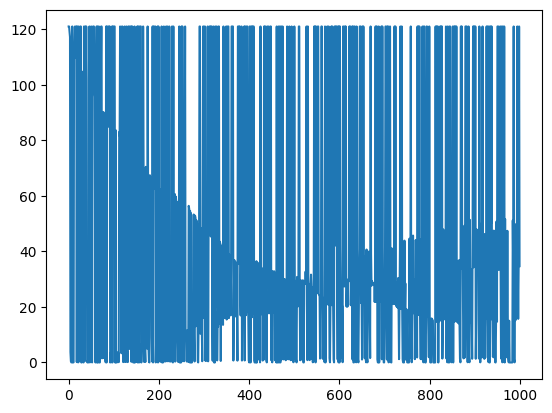

Weights: odict_values([tensor([[0.4911, 3.5101]])])


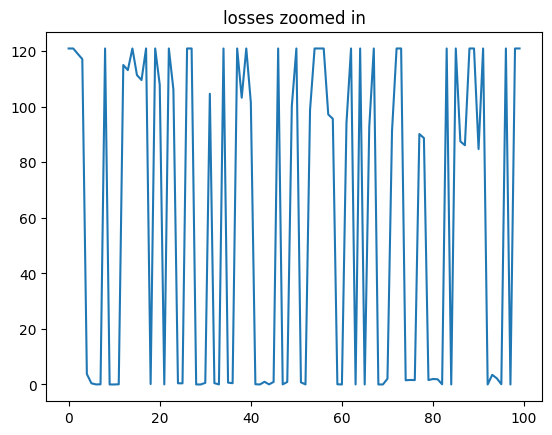

In [11]:
class Dropout(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    def forward(self, x):
        if self.training:
             mask = (torch.rand(*x.shape) > self.p)
             x = (1/ (1 - self.p)) * (x * mask)
             return x
        else:
            return x

def init_with_dropout(p):
    net = torch.nn.Sequential(
        Dropout(p),
        torch.nn.Linear(2, 1, bias=False)
    )
    # Initialize weights with 0
    net.load_state_dict({k: v * 0 for k, v in net.state_dict().items()})
    return net

net = init_with_dropout(0.5)
losses = train_simple(net)
plt.title('losses zoomed in')
plt.plot(losses[:100])
plt.show()

### Question

**Describe the shape of the training curve. Are the weights obtained by training with gradient descent the same as those calculated using the closed-form least squares method?** Answer this question in your written assignment.

## Dropout, Gradient Descent with Larger Batch Sizes

Run the cell below, which uses a larger batch.

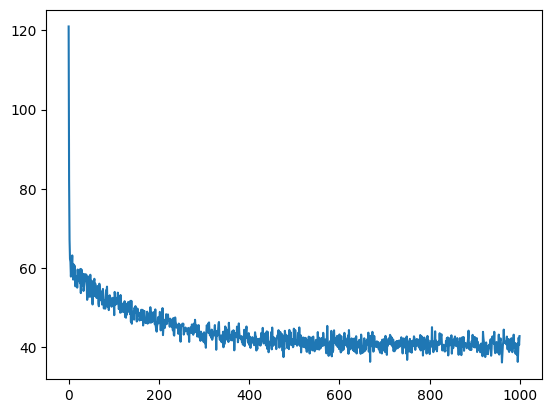

Weights: odict_values([tensor([[0.3726, 3.4833]])])


In [12]:
net = init_with_dropout(0.5)
losses = train_simple(net, batch_size=1024)

### Question

**Describe the loss curve and compare it with the loss curve in the last part. Why are they different? Also compare the trained weights with the one calculated by the least-square formula.** Answer this question in your written assignment.

# (G) [OPTIONAL]: Sweeping over dropout rate

Now, let's see how different dropout rates affect the final solution. Run the cell below to sweep over dropout rates. Since the 4 data points we considered in part (C) are no longer equally likely, we need to weight each data point by its probability of occuring. This turns it into a weighted linear regression problem. The analytic solution for this problem is:

$$w = (X^\top S X)^{-1} X^\top S y$$

where $S$ is the diagonal matrix of probabilities of each data point occuring.

Implement the analytic solution in the cell below, and show that the analytic solution matches the empirical solution. You should see that as the dropout rate changes, $w_1$ and $w_2$ change smoothly, except for a discontinuity when dropout rates are 0. Explain this discontinuity.

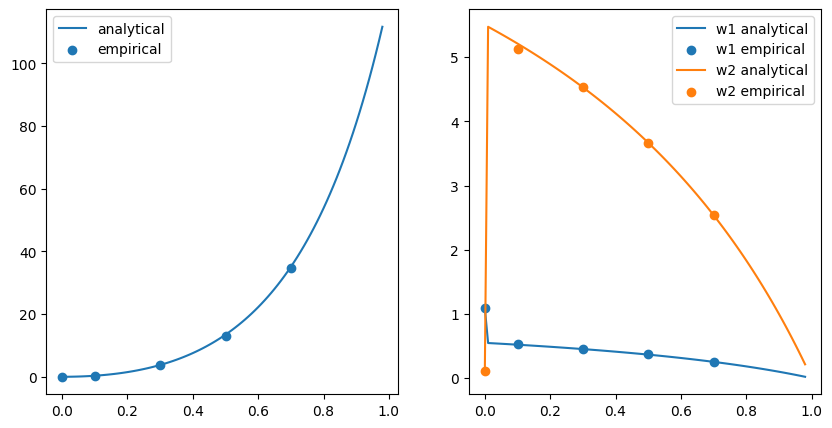

In [13]:
def init_with_dropout(p):
    net = torch.nn.Sequential(
        Dropout(p),
        torch.nn.Linear(2, 1, bias=False)
    )
    net.load_state_dict({k: v * 0 for k, v in net.state_dict().items()})
    return net

empirical_dropout_rates = [0, .1, .3, .5, .7]
analytical_dropout_rates = np.arange(0, .99, .01)
losses_empirical, losses_analytical = [], []
w1_empirical, w2_empirical, w1_analytical, w2_analytical = [], [], [], []
for p in analytical_dropout_rates:
    # compute analytical solution

    x = np.array([[10,1], [10, 0], [0, 1], [0, 0]]) / (1 - p)
    y = np.array([[11], [11], [11], [11]])
    s = np.diag(np.array([(1 - p)**2, + p * (1-p), p * (1 - p), p ** 2]))
    w_analytic = np.linalg.pinv(x.T @ s @ x) @ x.T @ s @ y
    x = np.array([[10, 1]])
    y = np.array([[11]])
    l_analytic = ((x @ w_analytic - y) ** 2).item()
    w1_analytical.append(w_analytic[0][0])
    w2_analytical.append(w_analytic[1][0])
    losses_analytical.append(l_analytic)

for p in empirical_dropout_rates:
    net = init_with_dropout(p)
    losses = train_simple(net, batch_size=1024, itrs=10000, plot=False)
    net.eval()
    losses_empirical.append(((net(torch.FloatTensor(x)) - torch.FloatTensor(y)) ** 2).item())
    w1_empirical.append(net.state_dict()['1.weight'][0][0].item())
    w2_empirical.append(net.state_dict()['1.weight'][0][1].item())
# Plot all saved values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(analytical_dropout_rates, losses_analytical, label='analytical')
plt.scatter(empirical_dropout_rates, losses_empirical, label='empirical')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(analytical_dropout_rates, w1_analytical, label='w1 analytical')
plt.scatter(empirical_dropout_rates, w1_empirical, label='w1 empirical')
plt.plot(analytical_dropout_rates, w2_analytical, label='w2 analytical')
plt.scatter(empirical_dropout_rates, w2_empirical, label='w2 empirical')
plt.legend()
plt.show()


# (H) [OPTIONAL]: Adding Adam

Now, let's add Adam to our network. Run the cell below to train with Adam with and without dropout. Does the solution change? Why or why not?

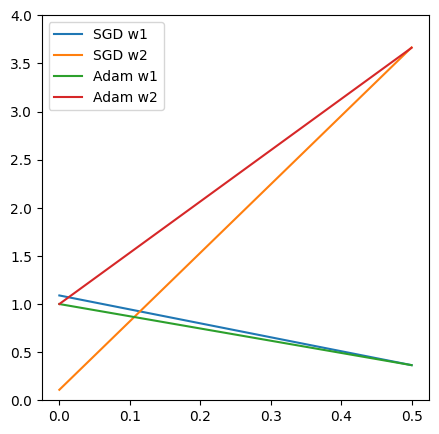

In [14]:
dropout_rates = [0, .5]
optim_classes = [torch.optim.SGD, torch.optim.Adam]

# Two plots, one for w1 and one for w2
fig, axs = plt.subplots(figsize=(5, 5))

for optim_class in optim_classes:
    w1_list = []
    w2_list = []
    for p in dropout_rates:
        net = init_with_dropout(p).train()
        losses = train_simple(net, batch_size=1024, itrs=10000, optim_class=optim_class, plot=False)
        net.eval()
        w1_list.append(net.state_dict()['1.weight'][0][0].item())
        w2_list.append(net.state_dict()['1.weight'][0][1].item())
    axs.plot(dropout_rates, w1_list, label=f'{optim_class.__name__} w1')
    axs.plot(dropout_rates, w2_list, label=f'{optim_class.__name__} w2')
axs.legend()
axs.set_ylim(0, 4)
plt.show()



## (I): Dropout on real data

There are some unusual features of our previous problem:
- We only used a single datapoint
- We applied dropout to the inputs to the network, whereas in real problems it's typically applied to hidden units
- The network was so small that dropout significantly hurt performance. Typically, networks are large enough that they can fit the data well even with dropout.

To see the effect of dropout on a more realistic problem, we'll train a network on the CIFAR10 dataset and add a "cheating feature." In this case, the cheating feature consists of a few pixels in the bottom-right corner of the image which encode the class label*. We want to see how dropout helps the network learn to rely less heavily on this cheating feature. Run the next few cells and comment on how dropout affects the degree to which the network relies on the cheating feature. Which model does better on clean data?

*This is obviously a contrived cheating feature, but they can appear in real data -- for instance, if a particular camera was used to capture all images of a certain class, the model might learn to rely on subtle camera artifacts rather than the acutal image.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConvNet(torch.nn.Module):
    def __init__(self, dropout_rate=0):
        super(ConvNet, self).__init__()
        in_channels = 3
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding='same')
        img_size = 8
        self.fc1 = torch.nn.Linear(32 * img_size * img_size, 10)
        self.dropout_rate = dropout_rate

    def forward(self, x):
        # NOTE: we apply more dropout to this network than is typical so we can emphasize the effect.
        # It's more typical to apply dropout to only the fully connected layers.
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(x), 2))
        x = torch.nn.functional.dropout(x, training=self.training, p=self.dropout_rate)
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv2(x), 2))
        x = torch.nn.functional.dropout(x, training=self.training, p=self.dropout_rate)
        img_size = 8
        x = x.view(-1, 32 * img_size * img_size)
        x = torch.nn.functional.relu(self.fc1(x))
        return torch.nn.functional.log_softmax(x, dim=1)

In [ ]:
def add_cheating_feature(x_batch, y_batch):
    # Add the label on the bottom-right corner of the image, encoded in binary
    for i in range(x_batch.shape[0]):
        binary_list = [int(x) for x in bin(y_batch[i].item())[2:]]
        if len(binary_list) < 4:
            binary_list = [0] * (4 - len(binary_list)) + binary_list
        binary_label = torch.FloatTensor(binary_list) * 3
        x_batch[i, 0, -1, -4:] = binary_label
        x_batch[i, 1:, -1, -4:] = 1 - binary_label
    return x_batch

In [ ]:
# Load CIFAR10 data
from torchvision import datasets, transforms
# Nomalizing constants for CIFAR10
MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2023, 0.1994, 0.2010]
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(MEAN, STD)
                        ])),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(MEAN, STD)
                        ])),
    batch_size=1000, shuffle=True)



100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting data/cifar-10-python.tar.gz to data


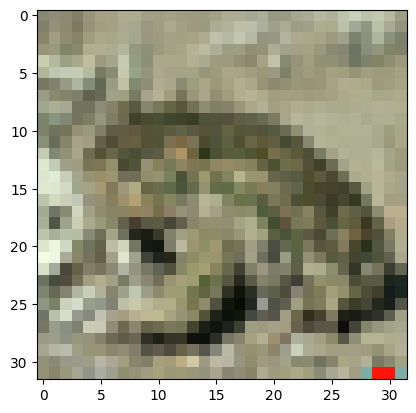

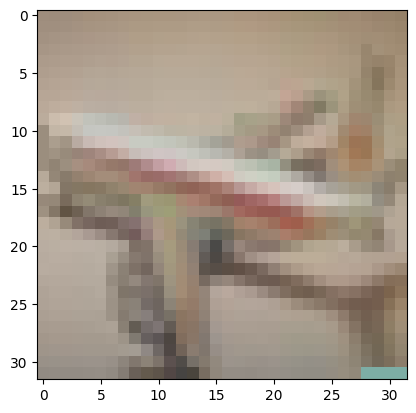

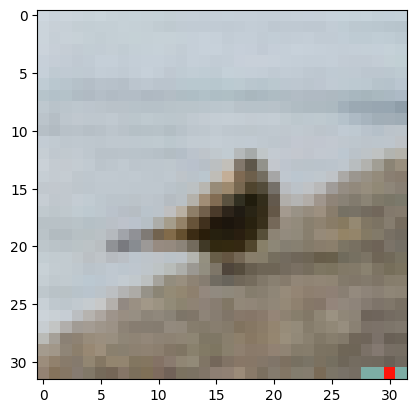

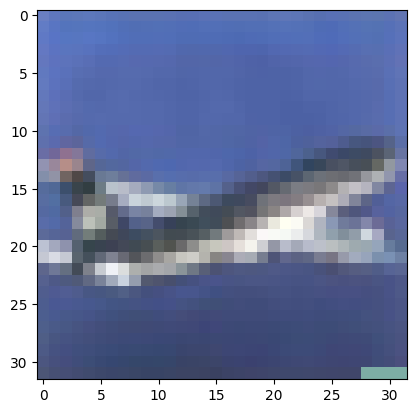

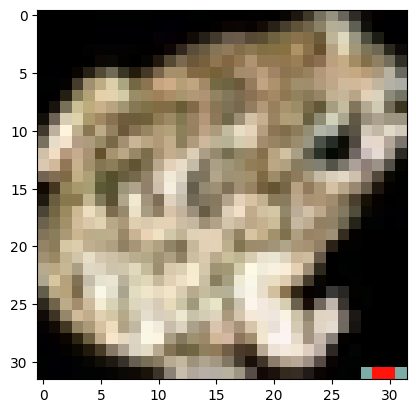

In [ ]:
# Visualize the data (note the black and white pixels in the corner)
# Images will appear to be overly saturated since matplotlib clips values outside of [0, 1]
def visualize_data():
    for _ in range(5):
        # Get a batch of training data
        x_batch, y_batch = next(iter(train_loader))
        # Add the cheating feature
        x_batch = add_cheating_feature(x_batch, y_batch)
        # Plot the first image in the batch, with the cheating feature
        # Move the channels to the end
        x_batch = x_batch.permute(0, 2, 3, 1)
        # Undo the normalization
        x_batch = x_batch * torch.FloatTensor(STD).view(1, 1, 1, 3) + torch.FloatTensor(MEAN).view(1, 1, 1, 3)
        plt.imshow(x_batch[0])
        plt.show()
visualize_data()

In [ ]:
# Train the model
def train(model, num_epochs=15, lr=1e-3):
    all_train_losses = []
    all_val_losses = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(1, num_epochs + 1):
        train_losses = []
        model.train()
        for (data, target) in train_loader:
            # Put the data on the same device as the model
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            # add cheating feature
            data = add_cheating_feature(data, target)
            output = model(data)
            loss = torch.nn.CrossEntropyLoss()(output, target)
            loss.backward()
            train_losses.append(loss.item())
            train_losses = train_losses[-100:]
            optimizer.step()
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                # Put the data on the same device as the model
                data = data.to(device)
                target = target.to(device)
                # add cheating feature
                data = add_cheating_feature(data, target)
                output = model(data)
                test_loss += torch.nn.CrossEntropyLoss(reduction='sum')(output, target).item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        train_loss = np.mean(train_losses)
        print('Train Epoch: {} of {} Train Loss: {:.3f}, Val Loss: {:3f}, Val Accuracy: {:3f}'.format(
                    epoch, num_epochs, train_loss, test_loss, 100. * correct / len(test_loader.dataset)))
        all_train_losses.append(train_loss)
        all_val_losses.append(test_loss)
    plt.plot(all_train_losses)
    plt.plot(all_val_losses)
    plt.legend(['train', 'val'])
    plt.show()
    return all_train_losses, all_val_losses

In [ ]:
# Test how much the model uses the cheating feature
def test_cheating(model):
    model.eval()
    correct_cheating = 0
    correct_not_cheating = 0
    correct_random = 0
    for data, target in test_loader:
        # Put the data on the same device as the model
        data = data.to(device)
        target = target.to(device)
        # Test on clean data
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct_not_cheating += pred.eq(target.data.view_as(pred)).cpu().sum()
        # Test on data with cheating feature
        data_modified = add_cheating_feature(data.clone(), target)
        output = model(data_modified)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct_cheating += pred.eq(target.data.view_as(pred)).cpu().sum()
        correct_random += pred.eq(target.data.view_as(pred)).cpu().sum()
    print('Accuracy on clean data: {}/{} ({:.0f}%)'.format(
        correct_not_cheating, len(test_loader.dataset),
        100. * correct_not_cheating / len(test_loader.dataset)))
    print('Accuracy on data with cheating feature: {}/{} ({:.0f}%)'.format(
        correct_cheating, len(test_loader.dataset),
        100. * correct_cheating / len(test_loader.dataset)))

Train Epoch: 1 of 10 Train Loss: 1.978, Val Loss: 1.948634, Val Accuracy: 36.939999
Train Epoch: 2 of 10 Train Loss: 1.796, Val Loss: 1.780062, Val Accuracy: 42.950001
Train Epoch: 3 of 10 Train Loss: 1.497, Val Loss: 1.466263, Val Accuracy: 55.959999
Train Epoch: 4 of 10 Train Loss: 1.046, Val Loss: 1.056796, Val Accuracy: 70.730003
Train Epoch: 5 of 10 Train Loss: 0.779, Val Loss: 0.775893, Val Accuracy: 77.199997
Train Epoch: 6 of 10 Train Loss: 0.645, Val Loss: 0.624633, Val Accuracy: 79.089996
Train Epoch: 7 of 10 Train Loss: 0.555, Val Loss: 0.546951, Val Accuracy: 79.570000
Train Epoch: 8 of 10 Train Loss: 0.527, Val Loss: 0.505425, Val Accuracy: 79.839996
Train Epoch: 9 of 10 Train Loss: 0.472, Val Loss: 0.489276, Val Accuracy: 79.860001
Train Epoch: 10 of 10 Train Loss: 0.468, Val Loss: 0.480576, Val Accuracy: 79.949997


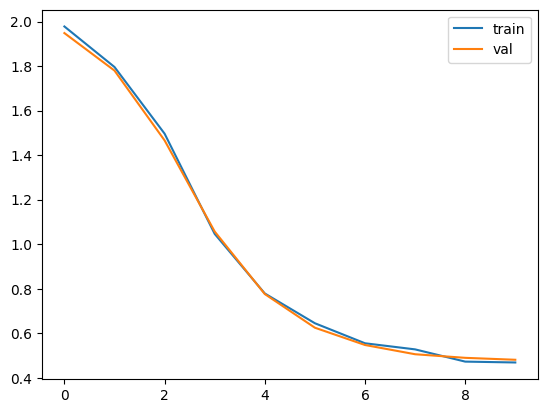

Accuracy on clean data: 1057/10000 (11%)
Accuracy on data with cheating feature: 7995/10000 (80%)


In [ ]:
model_no_dropout = ConvNet(dropout_rate=0)
# Put the model on the GPU, if available
model_no_dropout.to(device)
train_loss, val_loss = train(model_no_dropout, num_epochs=10, lr=3e-3)
test_cheating(model_no_dropout)

Train Epoch: 1 of 10 Train Loss: 2.303, Val Loss: 2.302585, Val Accuracy: 10.000000
Train Epoch: 2 of 10 Train Loss: 2.302, Val Loss: 2.302571, Val Accuracy: 10.000000
Train Epoch: 3 of 10 Train Loss: 2.294, Val Loss: 2.290791, Val Accuracy: 10.560000
Train Epoch: 4 of 10 Train Loss: 2.280, Val Loss: 2.273886, Val Accuracy: 10.990000
Train Epoch: 5 of 10 Train Loss: 2.257, Val Loss: 2.247087, Val Accuracy: 17.959999
Train Epoch: 6 of 10 Train Loss: 2.181, Val Loss: 2.193019, Val Accuracy: 21.900000
Train Epoch: 7 of 10 Train Loss: 2.094, Val Loss: 2.111713, Val Accuracy: 28.650000
Train Epoch: 8 of 10 Train Loss: 1.982, Val Loss: 1.996885, Val Accuracy: 34.119999
Train Epoch: 9 of 10 Train Loss: 1.860, Val Loss: 1.870918, Val Accuracy: 41.240002
Train Epoch: 10 of 10 Train Loss: 1.639, Val Loss: 1.589511, Val Accuracy: 50.939999


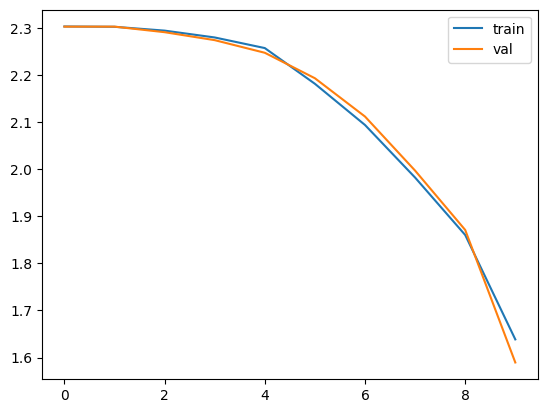

Accuracy on clean data: 3684/10000 (37%)
Accuracy on data with cheating feature: 5094/10000 (51%)


In [ ]:
model_dropout = ConvNet(dropout_rate=0.75)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dropout.to(device)
train_loss, val_loss = train(model_dropout, num_epochs=10, lr=3e-3)
test_cheating(model_dropout)